# Heart Condition Detection from Audio using CNN Architecture

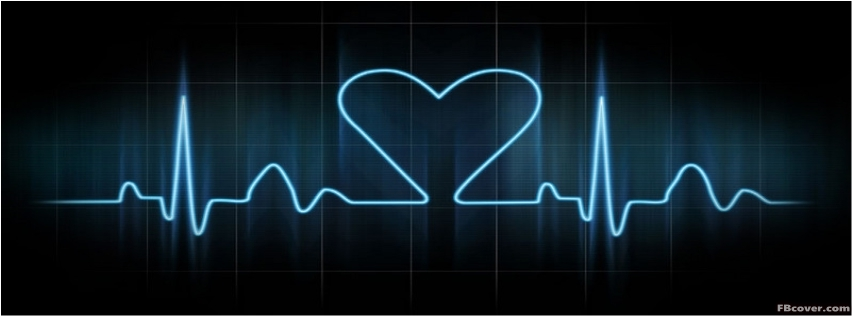

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools

# Build Dataset

In [2]:
%%time
dataset = []
for folder in ["C:/Users/KIIT/Desktop/66 Days of Data/Day100/set_a/**","C:/Users/KIIT/Desktop/66 Days of Data/Day100/set_b/**"]:
    for filename in glob.iglob(folder):
        if os.path.exists(filename):
            label = os.path.basename(filename).split("_")[0]
            # skip audio smaller than 4 secs
            if librosa.get_duration(filename=filename)>=4:
                if label not in ["Aunlabelledtest", "Bunlabelledtest"]:
                    dataset.append({
                        "filename": filename,
                        "label": label
                    })
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=42)

Wall time: 401 ms


In [3]:
dataset.head()

filename     label
70   C:/Users/KIIT/Desktop/66 Days of Data/Day100/s...    murmur
218  C:/Users/KIIT/Desktop/66 Days of Data/Day100/s...    normal
384  C:/Users/KIIT/Desktop/66 Days of Data/Day100/s...    normal
33   C:/Users/KIIT/Desktop/66 Days of Data/Day100/s...  artifact
42   C:/Users/KIIT/Desktop/66 Days of Data/Day100/s...  extrahls

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404 entries, 70 to 102
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  404 non-null    object
 1   label     404 non-null    object
dtypes: object(2)
memory usage: 9.5+ KB


In [5]:
import plotly.express as px
fig = px.histogram(x=dataset.label)
fig.show()

# Heartbeat Samples of Each Type

In [6]:
normal_file='C:/Users/KIIT/Desktop/66 Days of Data/Day100/set_a/Aunlabelledtest__201106111419.wav'
import IPython.display as ipd
ipd.Audio(normal_file) 

In [7]:
normal_file='C:/Users/KIIT/Desktop/66 Days of Data/Day100/set_a/extrahls__201101091153.wav'
ipd.Audio(normal_file) 

In [8]:
normal_file='C:/Users/KIIT/Desktop/66 Days of Data/Day100/set_a/murmur__201108222223.wav'
ipd.Audio(normal_file) 

In [9]:
normal_file='C:/Users/KIIT/Desktop/66 Days of Data/Day100/set_b/extrastole__198_1308141739338_B1.wav'
ipd.Audio(normal_file) 

In [10]:
normal_file='C:/Users/KIIT/Desktop/66 Days of Data/Day100/set_a/artifact__201106031558.wav'
ipd.Audio(normal_file) 

# Splitting into Train and Test Dataset

In [11]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

print("Train:",len(train))
print("Test:",len(test))

Train: 323
Test: 81


# Audio plotting using Librosa

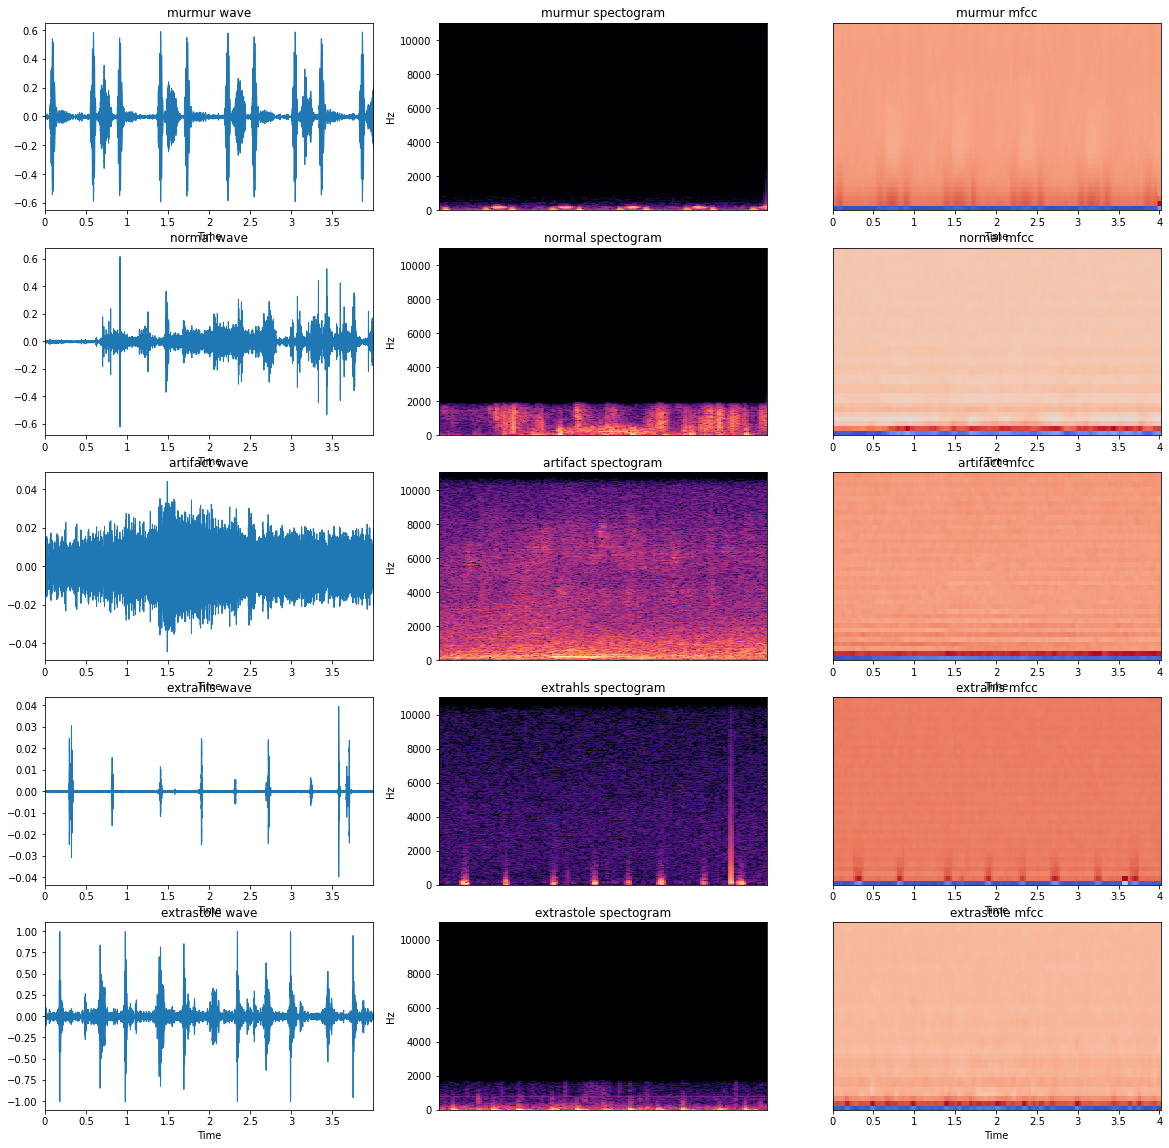

Wall time: 3.4 s


In [12]:
%%time
plt.figure(figsize=(20,20))
idx = 0
for label in dataset.label.unique():    
    y, sr = librosa.load(dataset[dataset.label==label].filename.iloc[0], duration=4)
    idx+=1
    plt.subplot(5, 3, idx)
    plt.title("%s wave" % label)
    librosa.display.waveplot(y, sr=sr)
    idx+=1
    plt.subplot(5, 3, idx)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, y_axis='linear')
    plt.title("%s spectogram" % label)
    idx+=1
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    plt.subplot(5, 3, idx)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.title("%s mfcc" % label)
plt.show()


# Extract Features from Audio

In [13]:
def extract_features(audio_path):
    y, sr = librosa.load(audio_path, duration=4)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfccs

In [14]:
%%time
x_train, x_test = [], []
print("Extract features from TRAIN  and TEST dataset")
for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx]))

for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx]))
    
    
x_test = np.asarray(x_test)
x_train = np.asarray(x_train)

print("X train:", x_train.shape)
print("X test:", x_test.shape)

  0%|          | 1/323 [00:00<00:47,  6.79it/s]

Extract features from TRAIN  and TEST dataset


100%|██████████| 81/81 [00:09<00:00,  8.41it/s]

X train: (323, 40, 173)
X test: (81, 40, 173)
Wall time: 45.6 s


# Feature Scaling

In [15]:
%%time
encoder = LabelEncoder()
encoder.fit(train.label)

y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)

Wall time: 0 ns


## X_train, X_test, Y_train, Y_test

In [16]:

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)



print("X train:", x_train.shape)
print("Y train:", y_train.shape)
print()
print("X test:", x_test.shape)
print("Y test:", y_test.shape)

X train: (323, 40, 173, 1)
Y train: (323, 5)

X test: (81, 40, 173, 1)
Y test: (81, 5)


# Building the CNN Model

In [17]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())

model.add(Dense(len(encoder.classes_), activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 172, 16)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 86, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 86, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 42, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 42, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 41, 64)         8

# Compiling with ADAM Optimizer and Binary Crossentropy Loss Function

In [18]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='ADAM')

# Fitting the Dataset into the Model

In [19]:
%%time
history = model.fit(x_train, y_train,
              batch_size=128,
              epochs=200,
              validation_data=(x_test, y_test),              
              shuffle=True)

Epoch 1/200
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
3/3 [==============================] - ETA: 0s - loss: 2.8194 - accuracy: 0.1672WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000026F00FD16A8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) a

3/3 [==============================] - 1s 253ms/step - loss: 0.2771 - accuracy: 0.6966 - val_loss: 0.3547 - val_accuracy: 0.6667
Epoch 46/200
3/3 [==============================] - 1s 222ms/step - loss: 0.2705 - accuracy: 0.7090 - val_loss: 0.3536 - val_accuracy: 0.6667
Epoch 47/200
3/3 [==============================] - 1s 214ms/step - loss: 0.2758 - accuracy: 0.7090 - val_loss: 0.3494 - val_accuracy: 0.6543
Epoch 48/200
3/3 [==============================] - 1s 211ms/step - loss: 0.2800 - accuracy: 0.6842 - val_loss: 0.3470 - val_accuracy: 0.6543
Epoch 49/200
3/3 [==============================] - 1s 199ms/step - loss: 0.2825 - accuracy: 0.6997 - val_loss: 0.3449 - val_accuracy: 0.6667
Epoch 50/200
3/3 [==============================] - 1s 201ms/step - loss: 0.2670 - accuracy: 0.7090 - val_loss: 0.3435 - val_accuracy: 0.6667
Epoch 51/200
3/3 [==============================] - 1s 197ms/step - loss: 0.2708 - accuracy: 0.6873 - val_loss: 0.3474 - val_accuracy: 0.6543
Epoch 52/200
3/3 [=

Epoch 103/200
3/3 [==============================] - 1s 256ms/step - loss: 0.2345 - accuracy: 0.7492 - val_loss: 0.3177 - val_accuracy: 0.6667
Epoch 104/200
3/3 [==============================] - 1s 260ms/step - loss: 0.2326 - accuracy: 0.7523 - val_loss: 0.3123 - val_accuracy: 0.6543
Epoch 105/200
3/3 [==============================] - 1s 223ms/step - loss: 0.2330 - accuracy: 0.7307 - val_loss: 0.3106 - val_accuracy: 0.6667
Epoch 106/200
3/3 [==============================] - 1s 224ms/step - loss: 0.2330 - accuracy: 0.7492 - val_loss: 0.3121 - val_accuracy: 0.6790
Epoch 107/200
3/3 [==============================] - 1s 222ms/step - loss: 0.2342 - accuracy: 0.7337 - val_loss: 0.3103 - val_accuracy: 0.6667
Epoch 108/200
3/3 [==============================] - 1s 218ms/step - loss: 0.2273 - accuracy: 0.7554 - val_loss: 0.3124 - val_accuracy: 0.6667
Epoch 109/200
3/3 [==============================] - 1s 212ms/step - loss: 0.2314 - accuracy: 0.7554 - val_loss: 0.3127 - val_accuracy: 0.6790

3/3 [==============================] - 1s 214ms/step - loss: 0.2016 - accuracy: 0.7926 - val_loss: 0.2975 - val_accuracy: 0.6790
Epoch 161/200
3/3 [==============================] - 1s 216ms/step - loss: 0.1978 - accuracy: 0.7833 - val_loss: 0.3027 - val_accuracy: 0.6667
Epoch 162/200
3/3 [==============================] - 1s 224ms/step - loss: 0.2042 - accuracy: 0.7864 - val_loss: 0.3099 - val_accuracy: 0.6667
Epoch 163/200
3/3 [==============================] - 1s 217ms/step - loss: 0.1974 - accuracy: 0.7895 - val_loss: 0.3143 - val_accuracy: 0.6296
Epoch 164/200
3/3 [==============================] - 1s 212ms/step - loss: 0.2044 - accuracy: 0.8111 - val_loss: 0.3055 - val_accuracy: 0.6790
Epoch 165/200
3/3 [==============================] - 1s 368ms/step - loss: 0.2017 - accuracy: 0.7895 - val_loss: 0.3123 - val_accuracy: 0.6543
Epoch 166/200
3/3 [==============================] - 1s 303ms/step - loss: 0.1883 - accuracy: 0.8019 - val_loss: 0.3060 - val_accuracy: 0.6543
Epoch 167/200

# Saving the trained Model

In [20]:
model_name = "heart.h5"
model.save(model_name)

# Model Evaluation

In [35]:
scores = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.3104674816131592
Test accuracy: 0.7066666865348816


# Prediction 

In [22]:
predictions = model.predict(x_test, verbose=1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
3/3 [==============================] - 0s 19ms/step


In [23]:
y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions): 
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])

# Classification Report

In [24]:
print(classification_report(y_pred, y_true))

              precision    recall  f1-score   support

    artifact       0.78      0.88      0.82         8
    extrahls       0.75      0.38      0.50         8
  extrastole       0.33      0.67      0.44         3
      murmur       0.67      0.64      0.65        25
      normal       0.68      0.70      0.69        37

    accuracy                           0.67        81
   macro avg       0.64      0.65      0.62        81
weighted avg       0.68      0.67      0.67        81



# Confusion Matrix

In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true,y_pred)
cm

array([[ 7,  1,  0,  1,  0],
       [ 0,  3,  0,  0,  1],
       [ 0,  0,  2,  0,  4],
       [ 0,  1,  1, 16,  6],
       [ 1,  3,  0,  8, 26]], dtype=int64)

<AxesSubplot:>

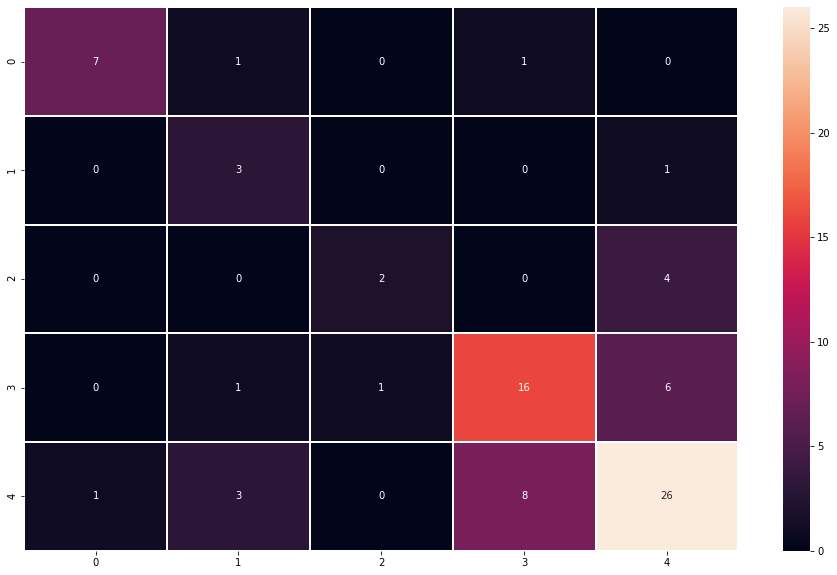

In [26]:
import seaborn as sns
plt.figure(figsize = (16, 10))
sns.heatmap(cm, annot= True, linewidth = 1)

# Plotting of Loss and Val_Loss

In [27]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(y=history.history['loss'], name='Actual Value',
                         line=dict(color='royalblue', width=5)))
fig.add_trace(go.Scatter(y=history.history['val_loss'], name = 'Predicted Value',
                         line=dict(color='firebrick', width=5)))


# Plotting of Accuracy and Val_Accuracy

In [28]:
fig = go.Figure()

fig.add_trace(go.Scatter(y=history.history['accuracy'], name='Actual Value',
                         line=dict(color='royalblue', width=5)))
fig.add_trace(go.Scatter(y=history.history['val_accuracy'], name = 'Predicted Value',
                         line=dict(color='firebrick', width=5)))

## This Model can Predict Heart Condition from Sounds with an Accuracy of 70%